In [1]:
# Подключаем необходимые библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchsummary import summary
from torchvision.transforms.v2 import ToDtype, ToTensor
from torchviz import make_dot
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image 

import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# Определяем гиперпараметры

batch_size = 32
num_epochs = 75
lr = 0.001
device = "cpu"

# Для transform

size = (64, 64)


if torch.cuda.is_available():
    device = torch.cuda

# cuda0 = torch.device('cuda')

print(device)
# print(cuda0)

cpu


In [3]:
# Путь к данным

data_dir = "./human_poses_data"
train_dir = os.path.join(data_dir, "img_train")
test_dir = os.path.join(data_dir, "img_test")
train_labels_path = os.path.join(data_dir, "train_answers.csv")

global_img_train_path = 'E:\ЯНДЕКС\Specializtaion project ML\ML-Project\human_poses_data\img_train'

# Чтение файла с метками
train_labels = pd.read_csv(train_labels_path)

print(data_dir)
train_labels['target_feature'].max()


./human_poses_data


18

In [4]:
train_labels

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6
...,...,...
12362,11503,4
12363,12201,6
12364,5489,3
12365,883,5


Добавим новые функции для сохранения чекпоинтов и модели.

[Saving and Loading Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [5]:
# Добавляем новые функции для сохранения чекпоинтов

def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    """Сохраняет чекпоинт модели и оптимизатора."""
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}, epoch {epoch}, loss {loss:.4f}")

def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    """Загружает чекпоинт модели и оптимизатора."""
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Checkpoint loaded: {filename}, epoch {epoch}, loss {loss:.4f}")
    return epoch, loss

In [15]:
# Произведем пребразования над данными для последующей их передачи в модель

# transform_train = transforms.Compose([
#     transforms.Resize(size=size), # Уменьшаем и приводим изображения к одному размеру
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# transform_test = transforms.Compose([
#     transforms.Resize(size=size), # Уменьшаем и приводим изображения к одному размеру
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# transform = transforms.Compose([
#     transforms.Resize(size=size),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     ToDtype(torch.float32, scale=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

train_transform = transforms.Compose([
    transforms.Resize(size=size), 
    transforms.RandomRotation(3),
    transforms.ColorJitter(brightness=1.5, saturation=0.2),
    transforms.RandomApply([transforms.RandomAffine(degrees=2, translate=(0.1, 0.1))]),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2)), transforms.RandomGrayscale()]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomChoice([transforms.RandomAdjustSharpness(1), transforms.RandAugment()]),
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform_for_visualize = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_val_transform = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
# Определим удобный класс Dataset для хранения данных

class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, labels_df=None, transform=None):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.img_files = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.labels_df) if self.labels_df is not None else len(os.listdir(self.img_dir))
    
    def __getitem__(self, index):
        img_name = self.img_files[index]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.labels_df is not None:
            img_id = int(os.path.splitext(img_name)[0])
            matching_rows = self.labels_df.loc[self.labels_df['img_id'] == img_id, "target_feature"]
            if not matching_rows.empty:
                label = matching_rows.values[0]
                return image, int(label)
            
        else:
            return image, img_name


In [9]:
# Создаем DataLoader

train_dataset = HumanPoseDataset(global_img_train_path, labels_df=train_labels, transform=train_transform)
train_dataset_view = HumanPoseDataset(global_img_train_path, labels_df=train_labels, transform=train_transform_for_visualize)
test_dataset = HumanPoseDataset(test_dir, transform=test_val_transform)

# Разделяем обучающий датасет на валидационную и обучающую выборки
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Создадим класс EarlyStopping для контроля переобучения

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [10]:
class ImprovedVGG(nn.Module):
    def __init__(self, num_classes=20):
        super(ImprovedVGG, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),  # Adjusted for the output size after feature extraction
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)  # Output layer for the number of classes
        )

    def forward(self, x):
        # print(x.shape)
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

In [11]:
# Выведем summary модели
num_classes = len(range(train_labels["target_feature"].min(), train_labels["target_feature"].max()))
print("Кол-во классов:", num_classes)

vgg = ImprovedVGG(num_classes=num_classes + 1).to(device)
print(vgg)

Кол-во классов: 18
ImprovedVGG(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   

In [190]:
# Воспользумся модулем torchviz для красивого отобржения архитектуры

dummy_input = torch.randn(1, 3, 64, 64)

output = vgg(dummy_input)
dot = make_dot(output, params=dict(vgg.named_parameters()))

dot.format = 'png'
dot.render('improvedVGG_model_graph')

'improvedVGG_model_graph.png'

In [191]:
# from IPython.display import Image
# Image(filename='improvedVGG_model_graph.png')

Original pictures:



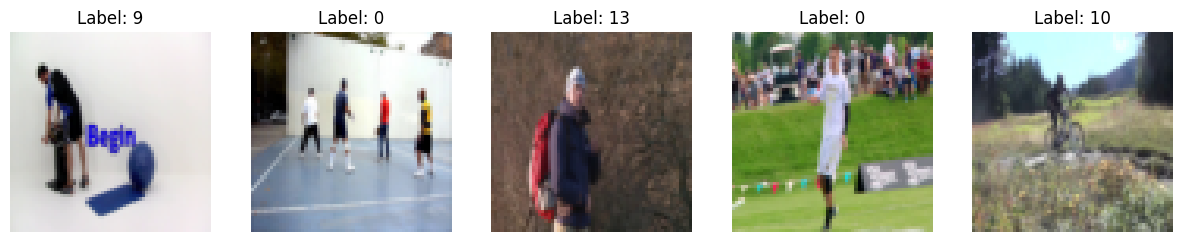

pictures after transforms:



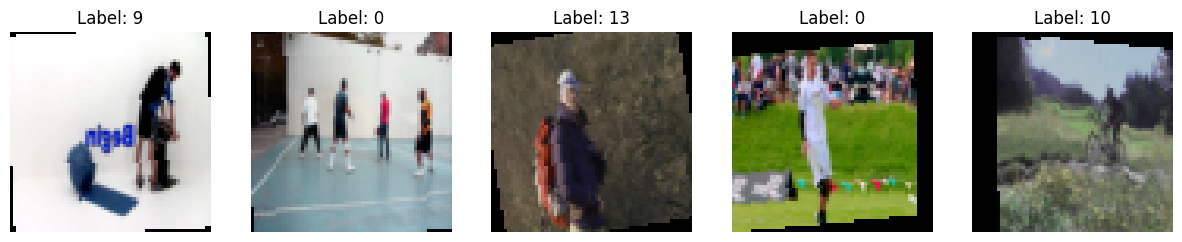

In [18]:
# Посмотрим на картинки в обучающей выборке

def show_images(dataset, num_images=5):
    """Функция для отображения нескольких изображений из датасета"""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, _label = dataset[i]  # Получаем изображение и метку
        # print(image)
        image = image.to(device).unsqueeze(0)
        # print(image)
        image = image.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5  # Меняем порядок осей для отображения и обратно нормализуем для отображения (если нормализовали)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {_label}")
        axes[i].axis("off")
    plt.show()

# Покажем несколько изображений из обучающего набора
print("Original pictures:\n")
show_images(train_dataset_view, num_images=5)
print("pictures after transforms:\n")
show_images(train_dataset, num_images=5)

**Изменим функцию обучения с добавлением чекпоинтов + scheduler**

In [23]:
# Early stopping
early_stopping = EarlyStopping(patience=2, delta=0.01)

# Функция обучения и оценки 

def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, num_epochs, 
                       lr=1e-3, checkpoint_dir='./checkpoints', checkpoint_path=None):
    train_losses, val_losses = [], []
    val_metrics = []

    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 0

    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    # Загрузка чекпоинта, если он указан
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        # Обучение
        model.train()
        train_loss = 0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}\{num_epochs} [Training]'):
            images = images.to(device)
            # images = images.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Оценка
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                images = images.to(device)
                # images = images.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average="weighted")
        rec = recall_score(all_labels, all_preds, average="weighted")
        f1 = f1_score(all_labels, all_preds, average="weighted")
        val_metrics.append((acc, prec, rec, f1))

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Acc: {acc:.4f}, Val Prec: {prec:.4f}, Val Recall: {rec:.4f}, Val F1: {f1:.4f}")
        
        scheduler.step(val_loss)

        # Сохранение чекпоинтов
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch{epoch + 1}_acc{acc:.4f}.pth")
            torch.save({'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'val_loss': val_loss}, checkpoint_path)

    return train_losses, val_losses, val_metrics

In [26]:
# Определяем критерий и оптимизатор
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(vgg.parameters(), lr=lr) 

In [34]:
# Функция для предсказания и сохранения результатов
def predict_and_save(model, test_loader, output_file):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, ids in tqdm(test_loader):  # img_name_batch нам не нужен для индексации
            images = images.to(device)
            # ids = ids.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            for img_id, pred in zip(ids, preds):
                predictions.append((img_id, pred))

    # Создаем DataFrame с индексами и предсказаниями
    results_df = pd.DataFrame(predictions, columns=['id', 'target_feature'])
    results_df['id'] = results_df['id'].str.replace(".jpg", "")

    # Сохраняем файл в формате CSV
    results_df.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в файл {output_file}")

In [201]:
# Сохраняем модель

torch.save(vgg, "vgg.pth")

In [202]:
checkpoint_path = "./checkpoints/model_epoch15_acc0.3668.pth"

In [203]:
# Запуск обучения и валидации. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(
    vgg, criterion, optimizer, train_loader, val_loader, num_epochs=75, lr=lr) 

Epoch 1/75 [Validation]: 100%|██████████| 78/78 [00:57<00:00,  1.36it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75, Train Loss: 2.6753, Val Loss: 2.4793, Val Acc: 0.2119, Val Prec: 0.1341, Val Recall: 0.2119, Val F1: 0.1362


Epoch 2/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.98it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/75, Train Loss: 2.5245, Val Loss: 2.4403, Val Acc: 0.2248, Val Prec: 0.1441, Val Recall: 0.2248, Val F1: 0.1457


Epoch 3/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.98it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/75, Train Loss: 2.4715, Val Loss: 2.3781, Val Acc: 0.2459, Val Prec: 0.2026, Val Recall: 0.2459, Val F1: 0.1670


Epoch 4/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.99it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/75, Train Loss: 2.4418, Val Loss: 2.3476, Val Acc: 0.2584, Val Prec: 0.1550, Val Recall: 0.2584, Val F1: 0.1710


Epoch 5/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/75, Train Loss: 2.4198, Val Loss: 2.3568, Val Acc: 0.2552, Val Prec: 0.1831, Val Recall: 0.2552, Val F1: 0.1632


Epoch 6/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.03it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6/75, Train Loss: 2.3762, Val Loss: 2.3148, Val Acc: 0.2782, Val Prec: 0.2008, Val Recall: 0.2782, Val F1: 0.2121


Epoch 7/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7/75, Train Loss: 2.3642, Val Loss: 2.3314, Val Acc: 0.2632, Val Prec: 0.1927, Val Recall: 0.2632, Val F1: 0.1849


Epoch 8/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.17it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8/75, Train Loss: 2.3174, Val Loss: 2.2156, Val Acc: 0.2863, Val Prec: 0.2679, Val Recall: 0.2863, Val F1: 0.2101


Epoch 9/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.16it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9/75, Train Loss: 2.2981, Val Loss: 2.2119, Val Acc: 0.2851, Val Prec: 0.2496, Val Recall: 0.2851, Val F1: 0.1964


Epoch 10/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10/75, Train Loss: 2.2809, Val Loss: 2.2028, Val Acc: 0.2960, Val Prec: 0.2651, Val Recall: 0.2960, Val F1: 0.2258


Epoch 11/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11/75, Train Loss: 2.2550, Val Loss: 2.1756, Val Acc: 0.3069, Val Prec: 0.2920, Val Recall: 0.3069, Val F1: 0.2332


Epoch 12/75 [Validation]: 100%|██████████| 78/78 [00:34<00:00,  2.24it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/75, Train Loss: 2.2439, Val Loss: 2.1677, Val Acc: 0.2976, Val Prec: 0.2714, Val Recall: 0.2976, Val F1: 0.2317


Epoch 13/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.16it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13/75, Train Loss: 2.2178, Val Loss: 2.1666, Val Acc: 0.3114, Val Prec: 0.2909, Val Recall: 0.3114, Val F1: 0.2370


Epoch 14/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/75, Train Loss: 2.1816, Val Loss: 2.1163, Val Acc: 0.3089, Val Prec: 0.3077, Val Recall: 0.3089, Val F1: 0.2390


Epoch 15/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15/75, Train Loss: 2.1591, Val Loss: 2.0706, Val Acc: 0.3267, Val Prec: 0.3352, Val Recall: 0.3267, Val F1: 0.2608


Epoch 16/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.19it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16/75, Train Loss: 2.1314, Val Loss: 2.0945, Val Acc: 0.3247, Val Prec: 0.3265, Val Recall: 0.3247, Val F1: 0.2745


Epoch 17/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.17it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/75, Train Loss: 2.1056, Val Loss: 2.0525, Val Acc: 0.3429, Val Prec: 0.3337, Val Recall: 0.3429, Val F1: 0.2858


Epoch 18/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.21it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18/75, Train Loss: 2.0918, Val Loss: 2.0192, Val Acc: 0.3469, Val Prec: 0.3287, Val Recall: 0.3469, Val F1: 0.2826


Epoch 19/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/75, Train Loss: 2.0713, Val Loss: 2.0087, Val Acc: 0.3522, Val Prec: 0.3210, Val Recall: 0.3522, Val F1: 0.3022


Epoch 20/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.02it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/75, Train Loss: 2.0362, Val Loss: 1.9595, Val Acc: 0.3651, Val Prec: 0.3444, Val Recall: 0.3651, Val F1: 0.3218


Epoch 21/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21/75, Train Loss: 2.0060, Val Loss: 1.9910, Val Acc: 0.3567, Val Prec: 0.3811, Val Recall: 0.3567, Val F1: 0.3070


Epoch 22/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.08it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22/75, Train Loss: 1.9684, Val Loss: 1.9556, Val Acc: 0.3757, Val Prec: 0.3531, Val Recall: 0.3757, Val F1: 0.3291


Epoch 23/75 [Validation]: 100%|██████████| 78/78 [00:46<00:00,  1.69it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23/75, Train Loss: 1.9585, Val Loss: 1.9515, Val Acc: 0.3724, Val Prec: 0.3676, Val Recall: 0.3724, Val F1: 0.3275


Epoch 24/75 [Validation]: 100%|██████████| 78/78 [00:46<00:00,  1.67it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24/75, Train Loss: 1.9256, Val Loss: 1.9253, Val Acc: 0.3837, Val Prec: 0.3811, Val Recall: 0.3837, Val F1: 0.3425


Epoch 25/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.88it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25/75, Train Loss: 1.9199, Val Loss: 1.8991, Val Acc: 0.3841, Val Prec: 0.4338, Val Recall: 0.3841, Val F1: 0.3484


Epoch 26/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.90it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26/75, Train Loss: 1.8646, Val Loss: 1.8885, Val Acc: 0.4011, Val Prec: 0.4636, Val Recall: 0.4011, Val F1: 0.3562


Epoch 27/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.81it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27/75, Train Loss: 1.8722, Val Loss: 1.8602, Val Acc: 0.3955, Val Prec: 0.3991, Val Recall: 0.3955, Val F1: 0.3504


Epoch 28/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.03it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28/75, Train Loss: 1.8372, Val Loss: 1.8832, Val Acc: 0.3926, Val Prec: 0.4476, Val Recall: 0.3926, Val F1: 0.3593


Epoch 29/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.18it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29/75, Train Loss: 1.8195, Val Loss: 1.8454, Val Acc: 0.4044, Val Prec: 0.4567, Val Recall: 0.4044, Val F1: 0.3694


Epoch 30/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30/75, Train Loss: 1.8026, Val Loss: 1.8308, Val Acc: 0.4209, Val Prec: 0.4571, Val Recall: 0.4209, Val F1: 0.3889


Epoch 31/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31/75, Train Loss: 1.7688, Val Loss: 1.8114, Val Acc: 0.4173, Val Prec: 0.4685, Val Recall: 0.4173, Val F1: 0.3765


Epoch 32/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.16it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32/75, Train Loss: 1.7517, Val Loss: 1.7839, Val Acc: 0.4258, Val Prec: 0.4719, Val Recall: 0.4258, Val F1: 0.3887


Epoch 33/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33/75, Train Loss: 1.7114, Val Loss: 1.7654, Val Acc: 0.4448, Val Prec: 0.5109, Val Recall: 0.4448, Val F1: 0.4142


Epoch 34/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.23it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34/75, Train Loss: 1.7103, Val Loss: 1.7654, Val Acc: 0.4395, Val Prec: 0.4891, Val Recall: 0.4395, Val F1: 0.4122


Epoch 35/75 [Validation]: 100%|██████████| 78/78 [00:35<00:00,  2.20it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35/75, Train Loss: 1.7010, Val Loss: 1.7684, Val Acc: 0.4420, Val Prec: 0.5244, Val Recall: 0.4420, Val F1: 0.4109


Epoch 36/75 [Validation]: 100%|██████████| 78/78 [00:48<00:00,  1.60it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36/75, Train Loss: 1.6846, Val Loss: 1.7532, Val Acc: 0.4476, Val Prec: 0.5194, Val Recall: 0.4476, Val F1: 0.4235


Epoch 37/75 [Validation]: 100%|██████████| 78/78 [00:45<00:00,  1.73it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/75, Train Loss: 1.6488, Val Loss: 1.7625, Val Acc: 0.4383, Val Prec: 0.5192, Val Recall: 0.4383, Val F1: 0.4047


Epoch 38/75 [Validation]: 100%|██████████| 78/78 [00:44<00:00,  1.74it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38/75, Train Loss: 1.6414, Val Loss: 1.7475, Val Acc: 0.4391, Val Prec: 0.4698, Val Recall: 0.4391, Val F1: 0.4099


Epoch 39/75 [Validation]: 100%|██████████| 78/78 [00:44<00:00,  1.76it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39/75, Train Loss: 1.6172, Val Loss: 1.7235, Val Acc: 0.4541, Val Prec: 0.5477, Val Recall: 0.4541, Val F1: 0.4274


Epoch 40/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40/75, Train Loss: 1.6098, Val Loss: 1.7234, Val Acc: 0.4594, Val Prec: 0.5506, Val Recall: 0.4594, Val F1: 0.4303


Epoch 41/75 [Validation]: 100%|██████████| 78/78 [00:45<00:00,  1.73it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41/75, Train Loss: 1.5940, Val Loss: 1.6873, Val Acc: 0.4650, Val Prec: 0.5094, Val Recall: 0.4650, Val F1: 0.4391


Epoch 42/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.09it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 42/75, Train Loss: 1.5505, Val Loss: 1.6842, Val Acc: 0.4767, Val Prec: 0.5151, Val Recall: 0.4767, Val F1: 0.4488


Epoch 43/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s]


Epoch 43/75, Train Loss: 1.5497, Val Loss: 1.6583, Val Acc: 0.4804, Val Prec: 0.5288, Val Recall: 0.4804, Val F1: 0.4551


Epoch 44/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.88it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 44/75, Train Loss: 1.5232, Val Loss: 1.6924, Val Acc: 0.4577, Val Prec: 0.5020, Val Recall: 0.4577, Val F1: 0.4362


Epoch 45/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]


Epoch 45/75, Train Loss: 1.5183, Val Loss: 1.6978, Val Acc: 0.4683, Val Prec: 0.5290, Val Recall: 0.4683, Val F1: 0.4459


Epoch 46/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 46/75, Train Loss: 1.4737, Val Loss: 1.6693, Val Acc: 0.4723, Val Prec: 0.5262, Val Recall: 0.4723, Val F1: 0.4525


Epoch 47/75 [Validation]: 100%|██████████| 78/78 [00:45<00:00,  1.72it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 47/75, Train Loss: 1.4781, Val Loss: 1.6900, Val Acc: 0.4780, Val Prec: 0.5453, Val Recall: 0.4780, Val F1: 0.4553


Epoch 48/75 [Validation]: 100%|██████████| 78/78 [00:44<00:00,  1.77it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 48/75, Train Loss: 1.4826, Val Loss: 1.6648, Val Acc: 0.4751, Val Prec: 0.5300, Val Recall: 0.4751, Val F1: 0.4536


Epoch 49/75 [Validation]: 100%|██████████| 78/78 [00:45<00:00,  1.72it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 49/75, Train Loss: 1.4538, Val Loss: 1.6853, Val Acc: 0.4662, Val Prec: 0.5172, Val Recall: 0.4662, Val F1: 0.4428


Epoch 50/75 [Validation]: 100%|██████████| 78/78 [00:46<00:00,  1.67it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 50/75, Train Loss: 1.3738, Val Loss: 1.6245, Val Acc: 0.4820, Val Prec: 0.5250, Val Recall: 0.4820, Val F1: 0.4678


Epoch 51/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 51/75, Train Loss: 1.3518, Val Loss: 1.5971, Val Acc: 0.5026, Val Prec: 0.5334, Val Recall: 0.5026, Val F1: 0.4852


Epoch 52/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 52/75, Train Loss: 1.3403, Val Loss: 1.5913, Val Acc: 0.4974, Val Prec: 0.5312, Val Recall: 0.4974, Val F1: 0.4795


Epoch 53/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 53/75, Train Loss: 1.3241, Val Loss: 1.5755, Val Acc: 0.5034, Val Prec: 0.5454, Val Recall: 0.5034, Val F1: 0.4904


Epoch 54/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 54/75, Train Loss: 1.2957, Val Loss: 1.5855, Val Acc: 0.5111, Val Prec: 0.5579, Val Recall: 0.5111, Val F1: 0.4944


Epoch 55/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.03it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 55/75, Train Loss: 1.2836, Val Loss: 1.5735, Val Acc: 0.5200, Val Prec: 0.5573, Val Recall: 0.5200, Val F1: 0.5072


Epoch 56/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 56/75, Train Loss: 1.2798, Val Loss: 1.5653, Val Acc: 0.5002, Val Prec: 0.5428, Val Recall: 0.5002, Val F1: 0.4883


Epoch 57/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.15it/s]


Epoch 57/75, Train Loss: 1.2703, Val Loss: 1.5908, Val Acc: 0.5087, Val Prec: 0.5306, Val Recall: 0.5087, Val F1: 0.4913


Epoch 58/75 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


Epoch 58/75, Train Loss: 1.2502, Val Loss: 1.6118, Val Acc: 0.5103, Val Prec: 0.5344, Val Recall: 0.5103, Val F1: 0.4978


Epoch 59/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.05it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 59/75, Train Loss: 1.2361, Val Loss: 1.5582, Val Acc: 0.5180, Val Prec: 0.5379, Val Recall: 0.5180, Val F1: 0.5045


Epoch 60/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 60/75, Train Loss: 1.2292, Val Loss: 1.5700, Val Acc: 0.5192, Val Prec: 0.5586, Val Recall: 0.5192, Val F1: 0.5058


Epoch 61/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.09it/s]


Epoch 61/75, Train Loss: 1.2158, Val Loss: 1.5648, Val Acc: 0.5156, Val Prec: 0.5567, Val Recall: 0.5156, Val F1: 0.5023


Epoch 62/75 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.06it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 62/75, Train Loss: 1.2025, Val Loss: 1.5879, Val Acc: 0.5131, Val Prec: 0.5246, Val Recall: 0.5131, Val F1: 0.5004


Epoch 63/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.86it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 63/75, Train Loss: 1.1963, Val Loss: 1.5619, Val Acc: 0.5127, Val Prec: 0.5486, Val Recall: 0.5127, Val F1: 0.4994


Epoch 64/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.81it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 64/75, Train Loss: 1.2005, Val Loss: 1.5219, Val Acc: 0.5285, Val Prec: 0.5562, Val Recall: 0.5285, Val F1: 0.5185


Epoch 65/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.78it/s]


Epoch 65/75, Train Loss: 1.1769, Val Loss: 1.5210, Val Acc: 0.5334, Val Prec: 0.5507, Val Recall: 0.5334, Val F1: 0.5197


Epoch 66/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.87it/s]


Epoch 66/75, Train Loss: 1.1594, Val Loss: 1.5746, Val Acc: 0.5293, Val Prec: 0.5548, Val Recall: 0.5293, Val F1: 0.5179


Epoch 67/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.84it/s]


Epoch 67/75, Train Loss: 1.1574, Val Loss: 1.5358, Val Acc: 0.5358, Val Prec: 0.5567, Val Recall: 0.5358, Val F1: 0.5246


Epoch 68/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.79it/s]


Epoch 68/75, Train Loss: 1.1644, Val Loss: 1.5195, Val Acc: 0.5410, Val Prec: 0.5746, Val Recall: 0.5410, Val F1: 0.5336


Epoch 69/75 [Validation]: 100%|██████████| 78/78 [00:42<00:00,  1.85it/s]


Epoch 69/75, Train Loss: 1.1474, Val Loss: 1.5099, Val Acc: 0.5346, Val Prec: 0.5588, Val Recall: 0.5346, Val F1: 0.5243


Epoch 70/75 [Validation]: 100%|██████████| 78/78 [00:39<00:00,  1.97it/s]


Epoch 70/75, Train Loss: 1.1282, Val Loss: 1.5290, Val Acc: 0.5419, Val Prec: 0.5646, Val Recall: 0.5419, Val F1: 0.5321


Epoch 71/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]


Epoch 71/75, Train Loss: 1.1197, Val Loss: 1.5271, Val Acc: 0.5398, Val Prec: 0.5672, Val Recall: 0.5398, Val F1: 0.5307


Epoch 72/75 [Validation]: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]


Epoch 72/75, Train Loss: 1.1084, Val Loss: 1.5370, Val Acc: 0.5317, Val Prec: 0.5535, Val Recall: 0.5317, Val F1: 0.5193


Epoch 73/75 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]


Epoch 73/75, Train Loss: 1.0897, Val Loss: 1.4985, Val Acc: 0.5483, Val Prec: 0.5830, Val Recall: 0.5483, Val F1: 0.5382


Epoch 74/75 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.86it/s]


Epoch 74/75, Train Loss: 1.0984, Val Loss: 1.4709, Val Acc: 0.5475, Val Prec: 0.5761, Val Recall: 0.5475, Val F1: 0.5373


Epoch 75/75 [Validation]: 100%|██████████| 78/78 [00:44<00:00,  1.76it/s]


Epoch 75/75, Train Loss: 1.0970, Val Loss: 1.5210, Val Acc: 0.5467, Val Prec: 0.5568, Val Recall: 0.5467, Val F1: 0.5361


In [204]:
torch.save(vgg.state_dict(), 'final_vgg_75.pth')

In [44]:
# vgg = torch.load("final_vgg_75.pth")

train_losses, val_losses, val_metrics = train_and_evaluate(
    vgg, criterion, optimizer, train_loader, val_loader, num_epochs=100, lr=lr, checkpoint_path='./checkpoints/model_epoch75_acc0.5467.pth')


Resuming training from epoch 75


Epoch 76/100 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.01it/s]


Epoch 76/100, Train Loss: 1.2280, Val Loss: 0.9335, Val Acc: 0.7153, Val Prec: 0.7461, Val Recall: 0.7153, Val F1: 0.7117


Epoch 77/100 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]


Epoch 77/100, Train Loss: 1.2202, Val Loss: 0.9021, Val Acc: 0.7250, Val Prec: 0.7454, Val Recall: 0.7250, Val F1: 0.7217


Epoch 78/100 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s]


Epoch 78/100, Train Loss: 1.2339, Val Loss: 0.9236, Val Acc: 0.7133, Val Prec: 0.7358, Val Recall: 0.7133, Val F1: 0.7080


Epoch 79/100 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]


Epoch 79/100, Train Loss: 1.2408, Val Loss: 0.9228, Val Acc: 0.7157, Val Prec: 0.7367, Val Recall: 0.7157, Val F1: 0.7129


Epoch 80/100 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.07it/s]


Epoch 80/100, Train Loss: 1.2438, Val Loss: 0.9289, Val Acc: 0.7165, Val Prec: 0.7412, Val Recall: 0.7165, Val F1: 0.7133


Epoch 81/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.12it/s]


Epoch 81/100, Train Loss: 1.2422, Val Loss: 0.9091, Val Acc: 0.7279, Val Prec: 0.7472, Val Recall: 0.7279, Val F1: 0.7251


Epoch 82/100 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.05it/s]


Epoch 82/100, Train Loss: 1.2421, Val Loss: 0.9364, Val Acc: 0.7080, Val Prec: 0.7252, Val Recall: 0.7080, Val F1: 0.7035


Epoch 83/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


Epoch 83/100, Train Loss: 1.2212, Val Loss: 0.9495, Val Acc: 0.7161, Val Prec: 0.7409, Val Recall: 0.7161, Val F1: 0.7101


Epoch 84/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


Epoch 84/100, Train Loss: 1.2400, Val Loss: 0.9271, Val Acc: 0.7327, Val Prec: 0.7536, Val Recall: 0.7327, Val F1: 0.7266


Epoch 85/100 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.10it/s]


Epoch 85/100, Train Loss: 1.2100, Val Loss: 0.9143, Val Acc: 0.7186, Val Prec: 0.7377, Val Recall: 0.7186, Val F1: 0.7138


Epoch 86/100 [Validation]: 100%|██████████| 78/78 [00:37<00:00,  2.10it/s]


Epoch 86/100, Train Loss: 1.2476, Val Loss: 0.9375, Val Acc: 0.7214, Val Prec: 0.7378, Val Recall: 0.7214, Val F1: 0.7175


Epoch 87/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.14it/s]


Epoch 87/100, Train Loss: 1.2373, Val Loss: 0.9239, Val Acc: 0.7137, Val Prec: 0.7352, Val Recall: 0.7137, Val F1: 0.7096


Epoch 88/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.13it/s]


Epoch 88/100, Train Loss: 1.2455, Val Loss: 0.9180, Val Acc: 0.7129, Val Prec: 0.7298, Val Recall: 0.7129, Val F1: 0.7081


Epoch 89/100 [Validation]: 100%|██████████| 78/78 [00:48<00:00,  1.61it/s]


Epoch 89/100, Train Loss: 1.2072, Val Loss: 0.9206, Val Acc: 0.7218, Val Prec: 0.7434, Val Recall: 0.7218, Val F1: 0.7176


Epoch 90/100 [Validation]: 100%|██████████| 78/78 [00:50<00:00,  1.54it/s]


Epoch 90/100, Train Loss: 1.2157, Val Loss: 0.9459, Val Acc: 0.7133, Val Prec: 0.7394, Val Recall: 0.7133, Val F1: 0.7094


Epoch 91/100 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.88it/s]


Epoch 91/100, Train Loss: 1.2339, Val Loss: 0.9005, Val Acc: 0.7238, Val Prec: 0.7428, Val Recall: 0.7238, Val F1: 0.7198


Epoch 92/100 [Validation]: 100%|██████████| 78/78 [00:48<00:00,  1.60it/s]


Epoch 92/100, Train Loss: 1.2234, Val Loss: 0.9530, Val Acc: 0.7165, Val Prec: 0.7434, Val Recall: 0.7165, Val F1: 0.7114


Epoch 93/100 [Validation]: 100%|██████████| 78/78 [00:41<00:00,  1.86it/s]


Epoch 93/100, Train Loss: 1.2274, Val Loss: 0.9146, Val Acc: 0.7198, Val Prec: 0.7410, Val Recall: 0.7198, Val F1: 0.7152


Epoch 94/100 [Validation]: 100%|██████████| 78/78 [00:45<00:00,  1.73it/s]


Epoch 94/100, Train Loss: 1.2476, Val Loss: 0.9382, Val Acc: 0.7113, Val Prec: 0.7298, Val Recall: 0.7113, Val F1: 0.7074


Epoch 95/100 [Validation]: 100%|██████████| 78/78 [00:47<00:00,  1.63it/s]


Epoch 95/100, Train Loss: 1.2414, Val Loss: 0.9303, Val Acc: 0.7153, Val Prec: 0.7358, Val Recall: 0.7153, Val F1: 0.7104


Epoch 96/100 [Validation]: 100%|██████████| 78/78 [00:46<00:00,  1.69it/s]


Epoch 96/100, Train Loss: 1.2372, Val Loss: 0.9394, Val Acc: 0.7169, Val Prec: 0.7390, Val Recall: 0.7169, Val F1: 0.7123


Epoch 97/100 [Validation]: 100%|██████████| 78/78 [00:47<00:00,  1.64it/s]


Epoch 97/100, Train Loss: 1.2165, Val Loss: 0.9044, Val Acc: 0.7250, Val Prec: 0.7466, Val Recall: 0.7250, Val F1: 0.7215


Epoch 98/100 [Validation]: 100%|██████████| 78/78 [00:47<00:00,  1.64it/s]


Epoch 98/100, Train Loss: 1.2428, Val Loss: 0.9298, Val Acc: 0.7230, Val Prec: 0.7391, Val Recall: 0.7230, Val F1: 0.7200


Epoch 99/100 [Validation]: 100%|██████████| 78/78 [00:36<00:00,  2.11it/s]


Epoch 99/100, Train Loss: 1.2352, Val Loss: 0.9196, Val Acc: 0.7202, Val Prec: 0.7453, Val Recall: 0.7202, Val F1: 0.7151


Epoch 100/100 [Validation]: 100%|██████████| 78/78 [00:38<00:00,  2.04it/s]

Epoch 100/100, Train Loss: 1.2260, Val Loss: 0.9258, Val Acc: 0.7262, Val Prec: 0.7480, Val Recall: 0.7262, Val F1: 0.7215


In [45]:
# После обучения производим предсказания и сохраняем их в требуемый формат
output_file = "test_predictions_100.csv"
predict_and_save(vgg, test_loader, output_file) 

100%|██████████| 166/166 [00:50<00:00,  3.29it/s]

Предсказания сохранены в файл test_predictions_100.csv


In [46]:
# Функция для визуализации графика ошибок и метрик
def visualize_model_results(train_losses, val_losses, val_metrics, epochs):
    val_acc = [m[0] for m in val_metrics] 
    val_f1 = [m[3] for m in val_metrics]

    plt.figure(figsize=(12, 6)) 
    plt.subplot(1, 2, 1) 
    plt.plot(range(0, epochs), train_losses, label="Train Loss")
    plt.plot(range(0, epochs), val_losses, label="Val Loss")
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.title("Training Loss") 
    plt.legend() 

    plt.subplot(1, 2, 2) 
    plt.plot(val_acc, label="Validation Accuracy") 
    plt.plot(val_f1, label="Validation F1-Score") 
    plt.xlabel("Epoch") 
    plt.ylabel("Value") 
    plt.title("Validation Metrics") 
    plt.legend() 

    plt.tight_layout() 
    plt.show()

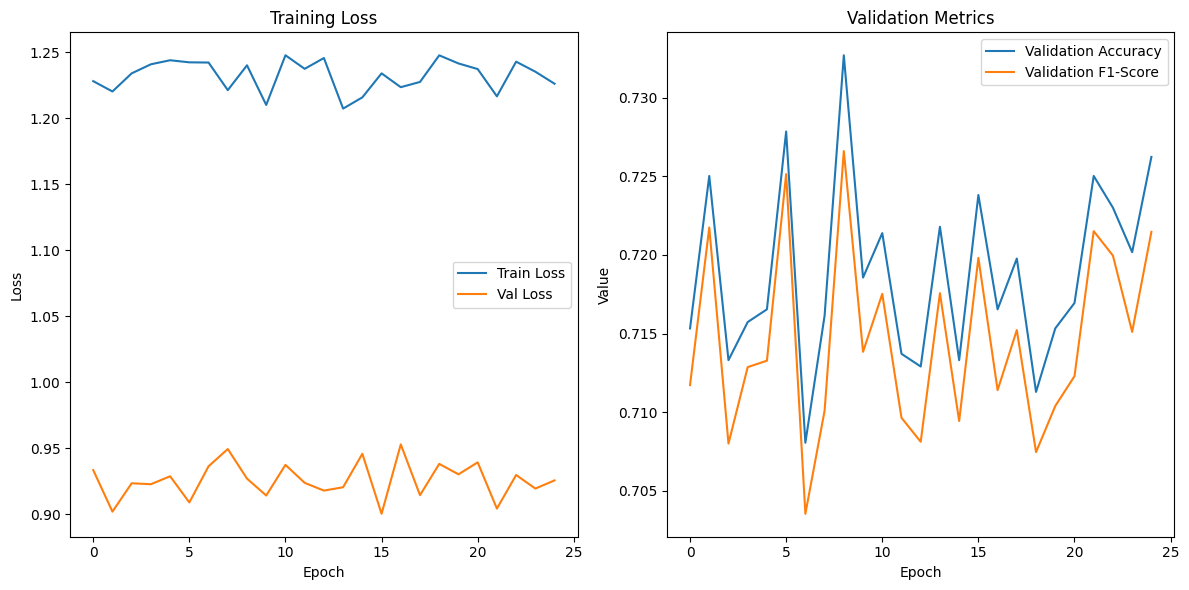

In [48]:
# Визуализация

visualize_model_results(train_losses, val_losses, val_metrics, epochs=25)

In [49]:
torch.save(vgg.state_dict(), 'final_vgg_100.pth')